## Multiple Time Series Modeling using Prophet and Auto_ARIMA<a id='multiple_ts'>

## Contents<a id='Contents'></a>
* [Mutliple Time Series Modeling](#multiple_ts)
  * [Contents](#Contents)
  * [Imports](#Imports)
  * [Load the Data](#load_data)
  * [Resampling the data](#resampling)
  * [checking for sectors with zero crimes](#zero_crimes)
  * [Save and retrieve data](#save_n_retrieve)
      * [PIVOT the data](#pivot)
      * [Split Data](#split_data)
      * [PMDARIMA - AUTO_ARIMA](#auto_arima)
           * [Separate the evaluation results based on the crime code](#separate_evals_arima)
          * [Auto Arima Model Evaluations on all Theft(code 600) Time Series](#auto_arima_600_eval)
          * [Auto Arima Model Evaluations on all Burglary(code 601)  Time Series](#auto_arima_601_eval)
      * [Prophet](#prophet)
          * [Separate the evaluation results based on the crime code](#separate_evals_prophet)
          * [Prophet Model Evaluations for Theft(code 600) for all APR Sectors](#prophet_eval_600)
          * [Prophet Model Evaluations for Burglary(code 601) for all APR Sectors](#prophet_eval_601)
          * [Theft(code 600) Forecast Plot for all the ten sectors](#forecast_plots_theft)
          * [Burglary(code 601) Forecast Plot](#forecast_plots_burglary)
  * [Summary](#summary)

### Imports<a id='imports'>
   

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from pylab import rcParams
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn import metrics
import pmdarima as pm
from pmdarima import auto_arima 
from math import sqrt
from prophet import Prophet
# Hyperparameter tuning
#import itertools
#from prophet.diagnostics import cross_validation, performance_metrics
# Tracking time
from time import time
import warnings
warnings.filterwarnings('ignore')

### Load Data<a id='load_data'>

In [2]:
#load dataset
df_crimes_summary_gp_apd_code = pd.read_csv('crimes_summary_gp_apd_code.csv', parse_dates=['occurred_date'])

In [3]:
df_crimes_summary_gp_apd_code.head()

,occurred_date,sector,ucr_code,count
0,2003-01-01,ADAM,1000,1
1,2003-01-01,ADAM,1199,1
2,2003-01-01,ADAM,1400,2
3,2003-01-01,ADAM,2100,2
4,2003-01-01,ADAM,2703,2


In [4]:
data2 = df_crimes_summary_gp_apd_code.loc[(df_crimes_summary_gp_apd_code['sector'].isin(['BAKER', 'FRANK', 'IDA', 'DAVID', 'ADAM', 'CHARLIE', 'HENRY',
       'GEORGE', 'EDWARD', 'APT']) ) & (df_crimes_summary_gp_apd_code['ucr_code'].isin([600,601])), ['occurred_date', 'sector', 'ucr_code', 'count']]

In [5]:
data2.shape

(119873, 4)

In [6]:
data2['occurred_date'] = pd.to_datetime(data2['occurred_date'])
data2['year'] = data2['occurred_date'].dt.year

In [7]:
data2.head()

,occurred_date,sector,ucr_code,count,year
12,2003-01-01,ADAM,600,4,2003
13,2003-01-01,ADAM,601,5,2003
31,2003-01-01,BAKER,600,3,2003
32,2003-01-01,BAKER,601,5,2003
52,2003-01-01,CHARLIE,600,4,2003


In [8]:
data2_2022 = data2[data2['year'] >= 2022]

In [9]:
data2_2022.head()

,occurred_date,sector,ucr_code,count,year
916194,2022-01-01,ADAM,600,2,2022
916195,2022-01-01,ADAM,601,1,2022
916207,2022-01-01,BAKER,601,8,2022
916217,2022-01-01,CHARLIE,600,2,2022
916218,2022-01-01,CHARLIE,601,4,2022


In [10]:
data2_2022 = data2_2022.reset_index()

In [11]:
data2_2022.head()

,index,occurred_date,sector,ucr_code,count,year
0,916194,2022-01-01,ADAM,600,2,2022
1,916195,2022-01-01,ADAM,601,1,2022
2,916207,2022-01-01,BAKER,601,8,2022
3,916217,2022-01-01,CHARLIE,600,2,2022
4,916218,2022-01-01,CHARLIE,601,4,2022


In [12]:
data2_2022.drop('index',axis=1,inplace=True)

In [13]:
data2_2022.head()

,occurred_date,sector,ucr_code,count,year
0,2022-01-01,ADAM,600,2,2022
1,2022-01-01,ADAM,601,1,2022
2,2022-01-01,BAKER,601,8,2022
3,2022-01-01,CHARLIE,600,2,2022
4,2022-01-01,CHARLIE,601,4,2022


In [14]:
data2_2022.shape

(6311, 5)

In [15]:
data2_2022.dtypes

occurred_date    datetime64[ns]
sector                   object
ucr_code                  int64
count                     int64
year                      int64
dtype: object

In [16]:
data2_2022['ucr_code'] = data2_2022['ucr_code'].astype(str)

In [17]:
data2_2022.dtypes

occurred_date    datetime64[ns]
sector                   object
ucr_code                 object
count                     int64
year                      int64
dtype: object

### Resampling the data<a id='resampling'>
    
* Upsampling is when the frequency of samples is increased (e.g. days to hours)
* Downsampling is when the frequency of samples is decreased (e.g. days to weeks)
I will do some downsampling with the .resample() function to reduce the noise.

<AxesSubplot:title={'center':'Resampled Weekly'}, xlabel='occurred_date', ylabel='count'>

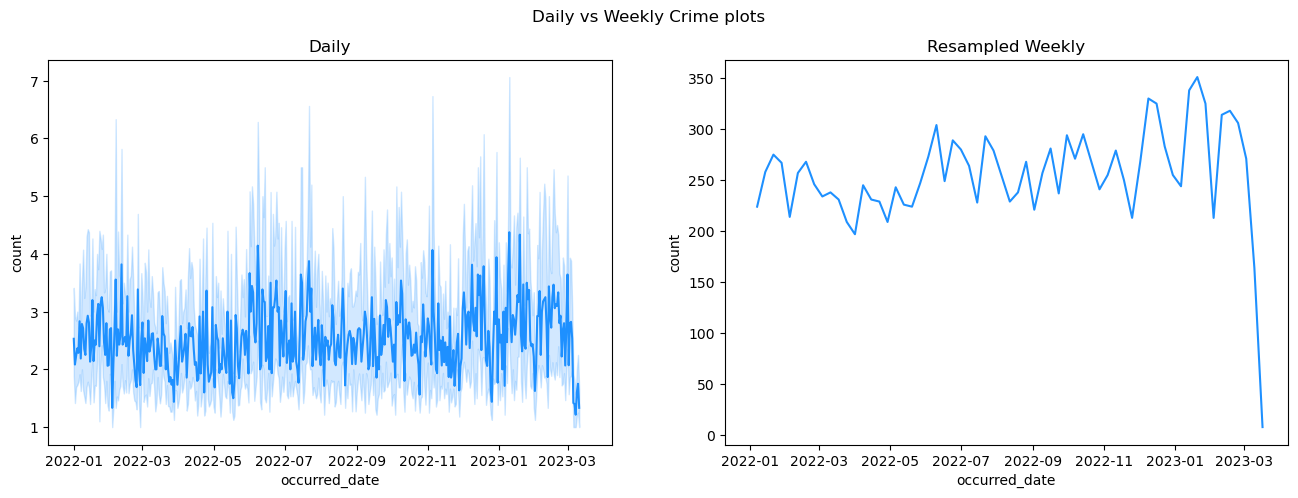

In [18]:
figure, axes = plt.subplots(1, 2, sharex=True,
                            figsize=(16, 5))
figure.suptitle('Daily vs Weekly Crime plots')
axes[0].set_title('Daily')
axes[1].set_title('Resampled Weekly')
sns.lineplot(x='occurred_date', y='count', data = data2_2022, color='dodgerblue', ax=axes[0])
resampled_df = data2_2022[['occurred_date','count']].resample('W-FRI', on='occurred_date').sum().reset_index(drop=False)
sns.lineplot(x='occurred_date', y='count',data=resampled_df, color='dodgerblue', ax=axes[1])


##### Downsampling the data using resample function

I had to use groupby based on categorical variables

In [19]:
weekly_data_adv =  data2_2022.groupby(['ucr_code','sector']).resample('W-FRI', label='right', closed = 'right', on='occurred_date').sum().reset_index().sort_values(by='occurred_date').reset_index()

In [20]:
weekly_data_adv.head()

,index,ucr_code,sector,occurred_date,count,year
0,0,600,ADAM,2022-01-07,13,10110
1,738,601,BAKER,2022-01-07,28,12132
2,1175,601,IDA,2022-01-07,11,8088
3,863,601,DAVID,2022-01-07,17,14154
4,62,600,APT,2022-01-07,1,2022


In [21]:
weekly_data_adv.drop('index',axis=1,inplace=True)

In [22]:
weekly_data_adv.head()

,ucr_code,sector,occurred_date,count,year
0,600,ADAM,2022-01-07,13,10110
1,601,BAKER,2022-01-07,28,12132
2,601,IDA,2022-01-07,11,8088
3,601,DAVID,2022-01-07,17,14154
4,600,APT,2022-01-07,1,2022


In [23]:
weekly_data_adv.year.unique()

array([10110, 12132,  8088, 14154,  2022,  6066,  4044,     0, 10114,
        8091, 14160, 12137,  8092,  2023, 10115, 12138, 14161,  6069,
        4046], dtype=int64)

In [24]:
weekly_data_adv.drop('year',axis=1,inplace=True)

In [25]:
weekly_data_adv.head()

,ucr_code,sector,occurred_date,count
0,600,ADAM,2022-01-07,13
1,601,BAKER,2022-01-07,28
2,601,IDA,2022-01-07,11
3,601,DAVID,2022-01-07,17
4,600,APT,2022-01-07,1


### Checking for sectors with zero crimes<a id='zero_crimes'>

In [26]:
weekly_data_adv[weekly_data_adv['count'] == 0]

,ucr_code,sector,occurred_date,count
139,600,APT,2022-02-25,0
149,601,APT,2022-02-25,0
157,601,APT,2022-03-04,0
191,601,APT,2022-03-11,0
202,601,APT,2022-03-18,0
221,601,APT,2022-03-25,0
257,601,APT,2022-04-08,0
283,600,APT,2022-04-15,0
292,601,APT,2022-04-15,0
340,601,APT,2022-05-06,0


### Save and retrieve data<a id='save_n_retrieve'>

In [27]:
#saving this weekly data  file
csv_name = "wkly_crimes_per_sector_ucr.csv"
weekly_data_adv.to_csv(csv_name, index=False)

In [28]:
weekly_data = pd.read_csv('wkly_crimes_per_sector_ucr.csv', parse_dates=['occurred_date'])

In [29]:
weekly_data.shape

(1237, 4)

In [30]:
# combine sector and ucr_code column as time_series
weekly_data['sector'] = ['sec_' + str(i) for i in weekly_data['sector']]
weekly_data['ucr_code'] = ['code_' + str(i) for i in weekly_data['ucr_code']]
weekly_data['time_series'] = weekly_data[['sector', 'ucr_code']].apply(lambda x: '_'.join(x), axis=1)

In [31]:
weekly_data = weekly_data.rename(columns={'occurred_date': 'ds', 'count': 'y'})

In [32]:
weekly_data.head()

,ucr_code,sector,ds,y,time_series
0,code_600,sec_ADAM,2022-01-07,13,sec_ADAM_code_600
1,code_601,sec_BAKER,2022-01-07,28,sec_BAKER_code_601
2,code_601,sec_IDA,2022-01-07,11,sec_IDA_code_601
3,code_601,sec_DAVID,2022-01-07,17,sec_DAVID_code_601
4,code_600,sec_APT,2022-01-07,1,sec_APT_code_600


## PIVOT the data<a id='pivot'>
    
 I am doing this so each Timeseries is on a separate column

In [33]:
pivoted_df = weekly_data.pivot(index='ds', columns='time_series', values='y')

print(pivoted_df.head())

time_series  sec_ADAM_code_600  sec_ADAM_code_601  sec_APT_code_600  \
ds                                                                    
2022-01-07                13.0               18.0               1.0   
2022-01-14                 7.0               22.0               2.0   
2022-01-21                11.0               25.0               6.0   
2022-01-28                11.0               12.0               1.0   
2022-02-04                 5.0               23.0               3.0   

time_series  sec_APT_code_601  sec_BAKER_code_600  sec_BAKER_code_601  \
ds                                                                      
2022-01-07                NaN                 8.0                28.0   
2022-01-14                NaN                 5.0                59.0   
2022-01-21                NaN                12.0                34.0   
2022-01-28                NaN                14.0                41.0   
2022-02-04                NaN                 6.0               

Filling up NaN values with zero

In [34]:
pivoted_df.replace(np.NaN, 0, inplace=True)

In [35]:
pivoted_df

time_series,sec_ADAM_code_600,sec_ADAM_code_601,sec_APT_code_600,sec_APT_code_601,sec_BAKER_code_600,sec_BAKER_code_601,sec_CHARLIE_code_600,sec_CHARLIE_code_601,sec_DAVID_code_600,sec_DAVID_code_601,sec_EDWARD_code_600,sec_EDWARD_code_601,sec_FRANK_code_600,sec_FRANK_code_601,sec_GEORGE_code_600,sec_GEORGE_code_601,sec_HENRY_code_600,sec_HENRY_code_601,sec_IDA_code_600,sec_IDA_code_601
ds,,,,,,,,,,,,,,,,,,,,
2022-01-07,13.0,18.0,1.0,0.0,8.0,28.0,7.0,17.0,13.0,17.0,12.0,8.0,9.0,15.0,5.0,4.0,6.0,23.0,9.0,11.0
2022-01-14,7.0,22.0,2.0,0.0,5.0,59.0,4.0,12.0,8.0,23.0,7.0,17.0,9.0,14.0,10.0,8.0,7.0,19.0,10.0,15.0
2022-01-21,11.0,25.0,6.0,0.0,12.0,34.0,11.0,8.0,9.0,29.0,13.0,16.0,14.0,24.0,9.0,13.0,3.0,22.0,8.0,8.0
2022-01-28,11.0,12.0,1.0,0.0,14.0,41.0,8.0,11.0,3.0,36.0,8.0,22.0,10.0,20.0,8.0,9.0,5.0,18.0,10.0,20.0
2022-02-04,5.0,23.0,3.0,0.0,6.0,28.0,7.0,8.0,10.0,16.0,11.0,8.0,4.0,13.0,11.0,4.0,11.0,25.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17,17.0,34.0,1.0,1.0,12.0,40.0,11.0,10.0,12.0,54.0,11.0,13.0,11.0,30.0,9.0,7.0,11.0,10.0,9.0,15.0
2023-02-24,12.0,33.0,2.0,0.0,13.0,43.0,13.0,10.0,25.0,40.0,11.0,13.0,13.0,18.0,9.0,6.0,12.0,6.0,6.0,21.0
2023-03-03,10.0,42.0,1.0,0.0,10.0,27.0,8.0,10.0,10.0,39.0,11.0,20.0,11.0,16.0,7.0,3.0,9.0,22.0,5.0,10.0


In [36]:
pivoted_df.shape

(63, 20)

In [37]:
pivoted_df.reset_index(inplace=True)

In [38]:
pivoted_df.head()

time_series,ds,sec_ADAM_code_600,sec_ADAM_code_601,sec_APT_code_600,sec_APT_code_601,sec_BAKER_code_600,sec_BAKER_code_601,sec_CHARLIE_code_600,sec_CHARLIE_code_601,sec_DAVID_code_600,...,sec_EDWARD_code_600,sec_EDWARD_code_601,sec_FRANK_code_600,sec_FRANK_code_601,sec_GEORGE_code_600,sec_GEORGE_code_601,sec_HENRY_code_600,sec_HENRY_code_601,sec_IDA_code_600,sec_IDA_code_601
0,2022-01-07,13.0,18.0,1.0,0.0,8.0,28.0,7.0,17.0,13.0,...,12.0,8.0,9.0,15.0,5.0,4.0,6.0,23.0,9.0,11.0
1,2022-01-14,7.0,22.0,2.0,0.0,5.0,59.0,4.0,12.0,8.0,...,7.0,17.0,9.0,14.0,10.0,8.0,7.0,19.0,10.0,15.0
2,2022-01-21,11.0,25.0,6.0,0.0,12.0,34.0,11.0,8.0,9.0,...,13.0,16.0,14.0,24.0,9.0,13.0,3.0,22.0,8.0,8.0
3,2022-01-28,11.0,12.0,1.0,0.0,14.0,41.0,8.0,11.0,3.0,...,8.0,22.0,10.0,20.0,8.0,9.0,5.0,18.0,10.0,20.0
4,2022-02-04,5.0,23.0,3.0,0.0,6.0,28.0,7.0,8.0,10.0,...,11.0,8.0,4.0,13.0,11.0,4.0,11.0,25.0,10.0,11.0


In [39]:
pivoted_df.tail()

time_series,ds,sec_ADAM_code_600,sec_ADAM_code_601,sec_APT_code_600,sec_APT_code_601,sec_BAKER_code_600,sec_BAKER_code_601,sec_CHARLIE_code_600,sec_CHARLIE_code_601,sec_DAVID_code_600,...,sec_EDWARD_code_600,sec_EDWARD_code_601,sec_FRANK_code_600,sec_FRANK_code_601,sec_GEORGE_code_600,sec_GEORGE_code_601,sec_HENRY_code_600,sec_HENRY_code_601,sec_IDA_code_600,sec_IDA_code_601
58,2023-02-17,17.0,34.0,1.0,1.0,12.0,40.0,11.0,10.0,12.0,...,11.0,13.0,11.0,30.0,9.0,7.0,11.0,10.0,9.0,15.0
59,2023-02-24,12.0,33.0,2.0,0.0,13.0,43.0,13.0,10.0,25.0,...,11.0,13.0,13.0,18.0,9.0,6.0,12.0,6.0,6.0,21.0
60,2023-03-03,10.0,42.0,1.0,0.0,10.0,27.0,8.0,10.0,10.0,...,11.0,20.0,11.0,16.0,7.0,3.0,9.0,22.0,5.0,10.0
61,2023-03-10,8.0,17.0,6.0,0.0,9.0,18.0,3.0,7.0,7.0,...,12.0,10.0,6.0,10.0,5.0,5.0,5.0,10.0,2.0,6.0
62,2023-03-17,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


## Split Data<a id='split_data'>

In [40]:
train_w = pivoted_df[pivoted_df['ds'] <= '2022-12-30'].copy()
test_w = pivoted_df[pivoted_df['ds'] > '2022-12-30'].copy()

In [41]:
train_w.shape, test_w.shape

((52, 21), (11, 21))

In [42]:
train_w.set_index('ds', inplace=True)

In [43]:
test_w.set_index('ds', inplace=True)

## PMDARIMA - AUTO_ARIMA<a id='auto_arima'>

In [44]:
import pmdarima as pmd

In [45]:
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    ##r2_square = metrics.r2_score(true, predicted)
   # ybar = np.sum(true) / len(true) #yes, we could use np.mean(y)
    #sum_sq_tot = np.sum((true - ybar)**2) #total sum of squares error
    #sum_sq_res = np.sum((true - predicted)**2) #residual sum of squares error
   # r2_square = 1.0 - sum_sq_res / sum_sq_tot
    ###
    ape = np.abs((true - predicted)/true)
    ape[~np.isfinite(ape)] = 1
    mape=round((np.mean(ape) *100),2)
    ### to calculate WMAPE, weighted MAPE, we need to first calculate weighter error. sum(weighter error) /sum(actual)
    #weighted error is calculated as: |actual-forecast| / |actual| * 100 * actual
    wmape=round((np.sum(abs(true-predicted))/np.sum(true)) * 100,2)
    return mae, mse, rmse, mape, wmape

In [46]:
def arimamodel(timeseriesarray):
    #future_forecast = pd.DataFrame()
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                            d=2, # maximum order of differencing
                            max_p=5,  # maximum order of AR terms
                            max_q=5,  # maximum order of MA terms
                            seasonal=False,  # non-seasonal data
                            suppress_warnings=True  # suppress convergence warnings
                            )
    return autoarima_model

In [47]:
%%time
# Start time
start_time = time()
# Fit the model for each time series
eval_results_df = pd.DataFrame()
for col in train_w.columns:
        arima_model = arimamodel(train_w[col])
        arima_model.summary()
        # Fit the model
        arima_model.fit(train_w[col])

        # Make predictions on the testing set
        preds = arima_model.predict(len(test_w))
        
        #print(f'{col}: MAE = {mae:.2f}')
        #plt.title("forecast for {}", col)

        # Model Evaluation
        results_df_2 = pd.DataFrame(data=[[col,  *evaluate(test_w[col], preds)]], 
                              columns=['Time Series', 'MAE', 'MSE', 'RMSE', 'MAPE', 'WMAPE'])
        eval_results_df = eval_results_df.append(results_df_2, ignore_index=True)
        
        print('The time used for the for-loop forecast is ', time()-start_time)
        #print("eval results: ",eval_results_df) 


The time used for the for-loop forecast is  1.9011223316192627
The time used for the for-loop forecast is  3.908596992492676
The time used for the for-loop forecast is  5.873556613922119
The time used for the for-loop forecast is  10.679220914840698
The time used for the for-loop forecast is  12.484846115112305
The time used for the for-loop forecast is  15.632169961929321
The time used for the for-loop forecast is  17.71446418762207
The time used for the for-loop forecast is  20.56706953048706
The time used for the for-loop forecast is  22.229476928710938
The time used for the for-loop forecast is  24.37235403060913
The time used for the for-loop forecast is  26.541592121124268
The time used for the for-loop forecast is  28.463842630386353
The time used for the for-loop forecast is  31.424926042556763
The time used for the for-loop forecast is  33.274569272994995
The time used for the for-loop forecast is  35.68387269973755
The time used for the for-loop forecast is  38.68218827247619

In [48]:
eval_results_df

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,5.255987,35.240957,5.936409,50.55,46.63
1,sec_ADAM_code_601,30.622345,1310.440403,36.200006,104.21,106.26
2,sec_APT_code_600,1.716303,3.815042,1.953213,79.01,82.08
3,sec_APT_code_601,1.438198,2.479228,1.574556,86.39,395.50
4,sec_BAKER_code_600,32.184972,1195.643741,34.578082,305.93,350.53
5,sec_BAKER_code_601,11.213140,210.924855,14.523252,182.78,34.94
6,sec_CHARLIE_code_600,3.589154,16.417885,4.051899,97.21,47.00
7,sec_CHARLIE_code_601,3.506373,20.202983,4.494773,31.32,33.83
8,sec_DAVID_code_600,20.246118,515.441883,22.703345,276.60,178.17
9,sec_DAVID_code_601,40.168878,1953.306671,44.196229,106.15,109.10


In [64]:
eval_results_df.head()

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,5.255987,35.240957,5.936409,50.55,46.63
1,sec_ADAM_code_601,30.622345,1310.440403,36.200006,104.21,106.26
2,sec_APT_code_600,1.716303,3.815042,1.953213,79.01,82.08
3,sec_APT_code_601,1.438198,2.479228,1.574556,86.39,395.50
4,sec_BAKER_code_600,32.184972,1195.643741,34.578082,305.93,350.53


In [181]:
eval_results_df.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,20.000000,20.000000,20.000000,20.00000,20.0000
mean,4.763934,51.370892,4.888725,55.00600,inf
std,5.294354,117.467758,5.377463,61.71789,NaN
min,0.680369,0.756084,0.869531,5.23000,5.2300
25%,1.782938,3.464504,1.853028,26.73250,26.7325
50%,2.803888,8.184722,2.860627,37.58500,37.5850
75%,4.936410,27.864149,5.067382,56.43500,56.4350
max,22.048909,504.459613,22.460178,280.58000,inf


### Separate the evaluation results based on the crime code<a id='separate_evals_arima'>

In [66]:
eval_results_df_600 = eval_results_df.loc[eval_results_df['Time Series'].str.contains("_600"),:].reset_index()

In [68]:
eval_results_df_600.drop('index',axis=1,inplace=True)

In [69]:
eval_results_df_600

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,5.255987,35.240957,5.936409,50.55,46.63
1,sec_APT_code_600,1.716303,3.815042,1.953213,79.01,82.08
2,sec_BAKER_code_600,32.184972,1195.643741,34.578082,305.93,350.53
3,sec_CHARLIE_code_600,3.589154,16.417885,4.051899,97.21,47.00
4,sec_DAVID_code_600,20.246118,515.441883,22.703345,276.60,178.17
5,sec_EDWARD_code_600,3.889597,20.204174,4.494905,37.84,38.90
6,sec_FRANK_code_600,5.752246,51.936584,7.206704,65.16,63.91
7,sec_GEORGE_code_600,4.327669,28.261708,5.316174,62.08,59.51
8,sec_HENRY_code_600,3.649645,25.887801,5.088006,146.27,38.23
9,sec_IDA_code_600,7.763218,86.149761,9.281690,158.92,118.60


In [73]:
#Theft summary on evaluations based on auto_arima 
eval_results_df_600.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,10.000000,10.000000,10.000000,10.000000,10.00000
mean,8.837491,197.899953,10.061043,127.957000,102.35600
std,9.711115,382.553221,10.364221,94.751459,97.54511
min,1.716303,3.815042,1.953213,37.840000,38.23000
25%,3.709633,21.625081,4.643180,62.850000,46.72250
50%,4.791828,31.751332,5.626292,88.110000,61.71000
75%,7.260475,77.596467,8.762943,155.757500,109.47000
max,32.184972,1195.643741,34.578082,305.930000,350.53000


In [70]:
eval_results_df_601 = eval_results_df.loc[eval_results_df['Time Series'].str.contains("_601"),:].reset_index()

In [71]:
eval_results_df_601.drop('index',axis=1,inplace=True)

In [72]:

eval_results_df_601

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_601,30.622345,1310.440403,36.200006,104.21,106.26
1,sec_APT_code_601,1.438198,2.479228,1.574556,86.39,395.50
2,sec_BAKER_code_601,11.213140,210.924855,14.523252,182.78,34.94
3,sec_CHARLIE_code_601,3.506373,20.202983,4.494773,31.32,33.83
4,sec_DAVID_code_601,40.168878,1953.306671,44.196229,106.15,109.10
5,sec_EDWARD_code_601,8.740270,102.617625,10.130036,85.34,65.85
6,sec_FRANK_code_601,13.253495,328.166260,18.115360,70.55,64.79
7,sec_GEORGE_code_601,2.956042,12.430229,3.525653,139.25,50.81
8,sec_HENRY_code_601,6.483419,57.999316,7.615728,57.91,50.22
9,sec_IDA_code_601,5.378141,48.774063,6.983843,42.73,37.21


In [74]:
#Burglary summary on evaluations based on auto_arima 
eval_results_df_601.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,12.376030,404.734163,14.735944,90.663000,94.851000
std,12.873090,671.944772,14.437071,45.476069,109.053836
min,1.438198,2.479228,1.574556,31.320000,33.830000
25%,3.974315,27.345753,5.117040,61.070000,40.462500
50%,7.611845,80.308470,8.872882,85.865000,57.800000
75%,12.743406,298.855909,17.217333,105.665000,96.157500
max,40.168878,1953.306671,44.196229,182.780000,395.500000


In [75]:
eval_results_df_600.set_index('Time Series',inplace=True)
eval_results_df_601.set_index('Time Series',inplace=True)

### Auto Arima Model Evaluations on all Theft(code 600)  Time Series<a id='auto_arima_600_eval'>

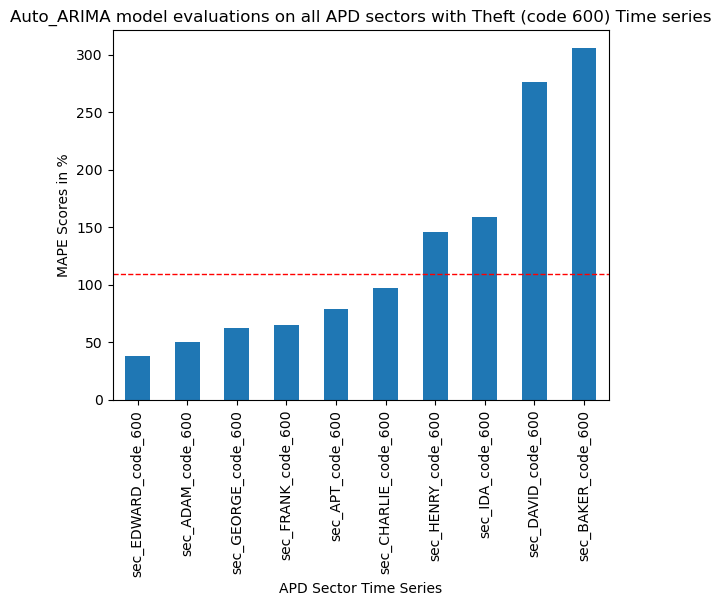

In [76]:
df_sorted = eval_results_df_600.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Auto_ARIMA model evaluations on all APD sectors with Theft (code 600) Time series")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')

### Auto Arima Model Evaluations on all Burglary(code 601)  Time Series<a id='auto_arima_601_eval'>

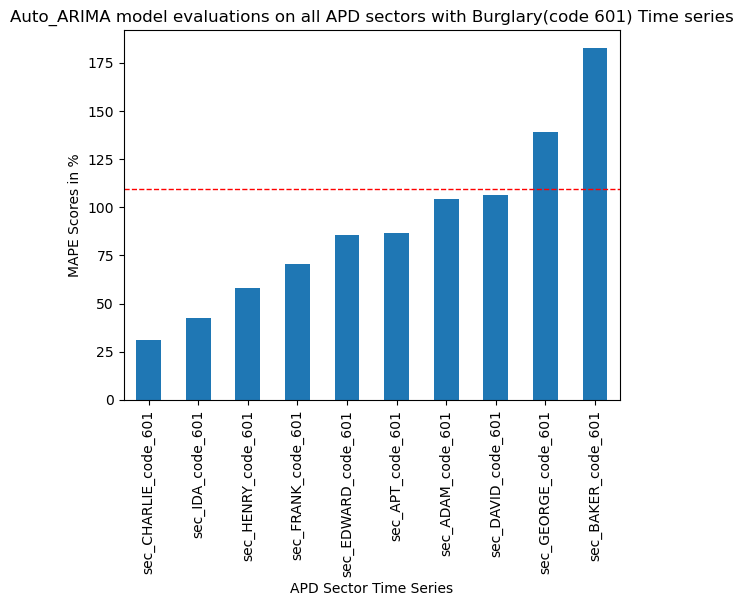

In [77]:
df_sorted = eval_results_df_601.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Auto_ARIMA model evaluations on all APD sectors with Burglary(code 601) Time series")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')

## PROPHET<a id='prophet'>

In [81]:
#pivoted_df.set_index('ds',inplace=True)

In [89]:
train_w.columns

Index(['sec_ADAM_code_600', 'sec_ADAM_code_601', 'sec_APT_code_600',
       'sec_APT_code_601', 'sec_BAKER_code_600', 'sec_BAKER_code_601',
       'sec_CHARLIE_code_600', 'sec_CHARLIE_code_601', 'sec_DAVID_code_600',
       'sec_DAVID_code_601', 'sec_EDWARD_code_600', 'sec_EDWARD_code_601',
       'sec_FRANK_code_600', 'sec_FRANK_code_601', 'sec_GEORGE_code_600',
       'sec_GEORGE_code_601', 'sec_HENRY_code_600', 'sec_HENRY_code_601',
       'sec_IDA_code_600', 'sec_IDA_code_601'],
      dtype='object', name='time_series')

In [82]:
#prophet_df = pivoted_df

In [96]:
#prophet_df.columns

In [84]:
# Reshape data into a suitable format for Prophet
#df = prophet_df.stack().reset_index()


In [91]:
df2 = train_w.stack().reset_index()


In [93]:
df2.columns = ['ds', 'series', 'y']

In [94]:
df2.head()

,ds,series,y
0,2022-01-07,sec_ADAM_code_600,13.0
1,2022-01-07,sec_ADAM_code_601,18.0
2,2022-01-07,sec_APT_code_600,1.0
3,2022-01-07,sec_APT_code_601,0.0
4,2022-01-07,sec_BAKER_code_600,8.0


In [104]:
df2_test = test_w.stack().reset_index()

In [105]:
df2_test.columns = ['ds', 'series', 'y']

In [106]:
df2.shape, df2_test.shape

((1040, 3), (220, 3))

In [85]:
#df.columns = ['ds', 'series', 'y']

In [97]:
#df.head()

In [98]:
#df.shape

In [107]:
def train_and_forecast(data_ts):
    # Instantiate the Prophet model
      model = Prophet()
  
      # Fit the model
      model.fit(data_ts)
      # Make predictions
      future = model.make_future_dataframe(len(df2_test))
      #print("future",future)
      forecast = model.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
      #forecast['sector'] = data_ts['time_series'].iloc[0]
      forecast['y'] = data_ts['y'].iloc[0]
      # Return the forecasted results
      return forecast[['ds','y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [108]:
%%time
# Start time
start_time = time()
# Create an empty dataframe
for_loop_forecast = pd.DataFrame()
eval_results_df = pd.DataFrame()
# Fit the model for each time series
for series_name in train_w.columns:
    ts_code = series_name
    # Filter the DataFrame to include only the data for this series
    series_data = df2[df2['series'] == series_name][['ds', 'y']]
    series_data.columns = ['ds', 'y']
    forecast = train_and_forecast(series_data)
    forecast['time_series'] = series_name
    # Plot the forecast
    #fig = model.plot(forecast)
    #fig.suptitle(series_name)
    y_true = forecast['y'].values
    y_pred = forecast['yhat'].values
    # Add the forecast results to the dataframe
    for_loop_forecast = pd.concat((for_loop_forecast, forecast))
    # Model Evaluation
    results_df_2 = pd.DataFrame(data=[[ts_code, *evaluate(y_true,y_pred)]], 
                              columns=['Time Series', 'MAE', 'MSE', 'RMSE', 'MAPE', 'WMAPE'])
    eval_results_df = eval_results_df.append(results_df_2, ignore_index=True)
        
    print('The time used for the for-loop forecast is ', time()-start_time)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  2.203967809677124


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  4.501837730407715


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  6.276933908462524


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  8.244883298873901


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  10.228486776351929


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  12.19896388053894


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  14.828279733657837


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  17.08729076385498


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  19.1473867893219


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  21.017695665359497


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  23.443044662475586


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  26.29788613319397


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  28.422940492630005


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  30.376815795898438


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  32.389851808547974


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  34.33050560951233


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  36.112658977508545


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  37.97351145744324


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  40.56989049911499
The time used for the for-loop forecast is  43.16086006164551
Wall time: 43.2 s


In [109]:
eval_results_df

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,0.680369,0.909027,0.953429,5.23,5.23
1,sec_ADAM_code_601,13.879380,207.858219,14.417289,77.11,77.11
2,sec_APT_code_600,2.805805,8.409088,2.899843,280.58,280.58
3,sec_APT_code_601,1.078022,1.307832,1.143605,100.00,inf
4,sec_BAKER_code_600,2.630580,7.214774,2.686033,32.88,32.88
5,sec_BAKER_code_601,8.020732,65.338022,8.083194,28.65,28.65
6,sec_CHARLIE_code_600,2.693301,7.442506,2.728096,38.48,38.48
7,sec_CHARLIE_code_601,7.619739,58.188143,7.628115,44.82,44.82
8,sec_DAVID_code_600,1.346710,2.399724,1.549104,10.36,10.36
9,sec_DAVID_code_601,22.048909,504.459613,22.460178,129.70,129.70


In [110]:
eval_results_df.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,20.000000,20.000000,20.000000,20.00000,20.0000
mean,4.763934,51.370892,4.888725,55.00600,inf
std,5.294354,117.467758,5.377463,61.71789,NaN
min,0.680369,0.756084,0.869531,5.23000,5.2300
25%,1.782938,3.464504,1.853028,26.73250,26.7325
50%,2.803888,8.184722,2.860627,37.58500,37.5850
75%,4.936410,27.864149,5.067382,56.43500,56.4350
max,22.048909,504.459613,22.460178,280.58000,inf


### Separate the evaluation results based on the crime code<a id='separate_evals_prophet'>

In [111]:
eval_results_df_prop_600 = eval_results_df.loc[eval_results_df['Time Series'].str.contains("_600"),:].reset_index()

In [113]:
eval_results_df_prop_600.drop('index',axis=1,inplace=True)

In [114]:
eval_results_df_prop_600

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,0.680369,0.909027,0.953429,5.23,5.23
1,sec_APT_code_600,2.805805,8.409088,2.899843,280.58,280.58
2,sec_BAKER_code_600,2.630580,7.214774,2.686033,32.88,32.88
3,sec_CHARLIE_code_600,2.693301,7.442506,2.728096,38.48,38.48
4,sec_DAVID_code_600,1.346710,2.399724,1.549104,10.36,10.36
5,sec_EDWARD_code_600,0.801573,0.756084,0.869531,6.68,6.68
6,sec_FRANK_code_600,2.871301,9.504988,3.083016,31.90,31.90
7,sec_GEORGE_code_600,3.708831,13.873181,3.724672,74.18,74.18
8,sec_HENRY_code_600,2.801970,7.960356,2.821410,46.70,46.70
9,sec_IDA_code_600,1.888086,3.819430,1.954336,20.98,20.98


In [119]:
eval_results_df_prop_600.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.222853,6.228916,2.326947,54.797000,54.797000
std,0.998353,4.191057,0.951159,82.043665,82.043665
min,0.680369,0.756084,0.869531,5.230000,5.230000
25%,1.482054,2.754651,1.650412,13.015000,13.015000
50%,2.661941,7.328640,2.707064,32.390000,32.390000
75%,2.804847,8.296905,2.880235,44.645000,44.645000
max,3.708831,13.873181,3.724672,280.580000,280.580000


In [115]:
eval_results_df_prop_601 = eval_results_df.loc[eval_results_df['Time Series'].str.contains("_601"),:].reset_index()

In [116]:
eval_results_df_prop_601.drop('index',axis=1,inplace=True)

In [117]:
eval_results_df_prop_601

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_601,13.879380,207.858219,14.417289,77.11,77.11
1,sec_APT_code_601,1.078022,1.307832,1.143605,100.00,inf
2,sec_BAKER_code_601,8.020732,65.338022,8.083194,28.65,28.65
3,sec_CHARLIE_code_601,7.619739,58.188143,7.628115,44.82,44.82
4,sec_DAVID_code_601,22.048909,504.459613,22.460178,129.70,129.70
5,sec_EDWARD_code_601,4.041967,17.756151,4.213805,50.52,50.52
6,sec_FRANK_code_601,2.080875,4.996064,2.235188,13.87,13.87
7,sec_GEORGE_code_601,1.467494,2.277815,1.509243,36.69,36.69
8,sec_HENRY_code_601,9.634485,92.840540,9.635380,41.89,41.89
9,sec_IDA_code_601,3.178559,10.106283,3.179038,28.90,28.90


In [118]:
eval_results_df_prop_601.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,10.000000,10.000000,10.000000,10.000000,10.0000
mean,7.305016,96.512868,7.450503,55.215000,inf
std,6.620350,156.794545,6.749722,36.196256,NaN
min,1.078022,1.307832,1.143605,13.870000,13.8700
25%,2.355296,6.273619,2.471150,30.847500,30.8475
50%,5.830853,37.972147,5.920960,43.355000,43.3550
75%,9.231047,85.964911,9.247333,70.462500,70.4625
max,22.048909,504.459613,22.460178,129.700000,inf


In [120]:
eval_results_df_prop_600.set_index('Time Series',inplace=True)
eval_results_df_prop_601.set_index('Time Series',inplace=True)

In [ ]:
#eval_results_df.set_index('Time Series',inplace=True)

### Prophet Model Evaluations for Theft(code 600) for all APR Sectors<a id='prophet_eval_600'>

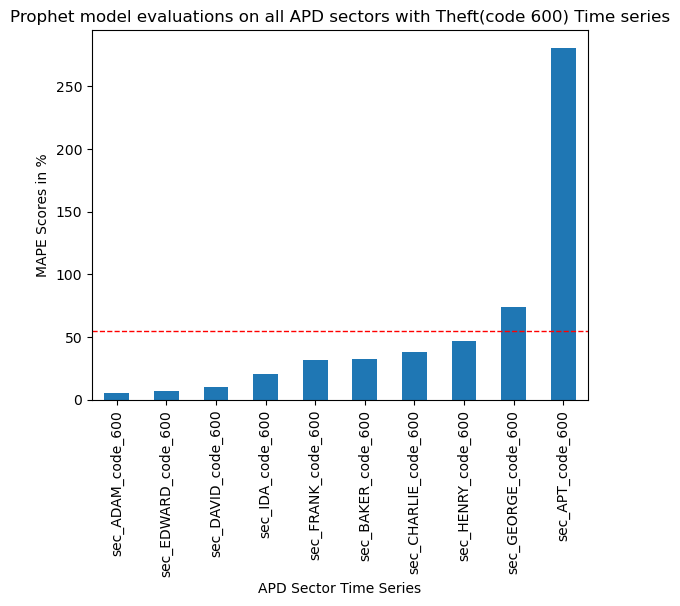

In [123]:
df_sorted = eval_results_df_prop_600.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Prophet model evaluations on all APD sectors with Theft(code 600) Time series")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')
#text_pos_x = 0.60
#text_pos_y = 0.50
#plt.text(text_pos_x, text_pos_y, "ucr_code:\n600-THEFTS\n601-BURGLARY", fontsize=9,
#transform=plt.gcf().transFigure, color='green')

### Prophet Model Evaluations for Burglary (code 601) for all APR Sectors<a id='prophet_eval_601'>

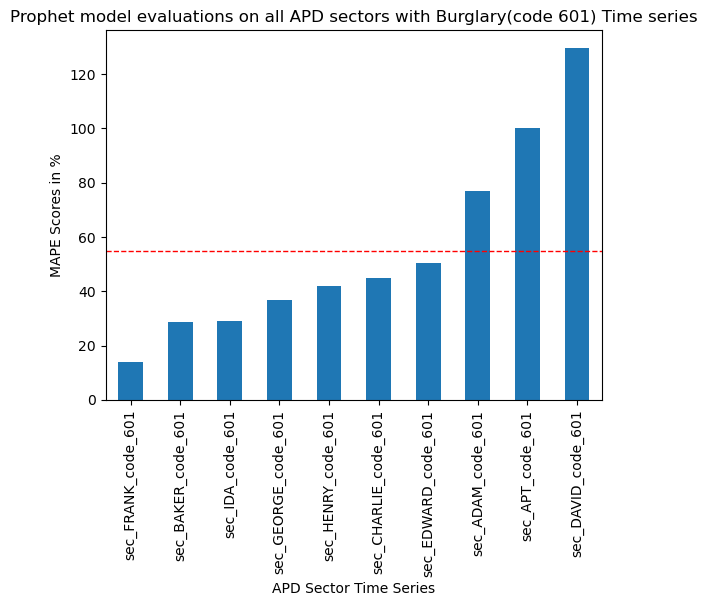

In [124]:
df_sorted = eval_results_df_prop_601.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Prophet model evaluations on all APD sectors with Burglary(code 601) Time series")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')

APT sector shows high MAPE scores probably due to lack of data in that sector. Refer Cell# 26 There are no crimes recorded for APT sector. 

Prophet model predicted some good results for some sectors like IDA, ADAM, EDWARD, DAVID, FRANK for Theft crime as they are below 20% 

In [125]:
for_loop_forecast

,ds,y,yhat,yhat_upper,yhat_lower,time_series
0,2022-01-07,13.0,9.984907,15.372456,4.716538,sec_ADAM_code_600
1,2022-01-14,13.0,10.033724,15.487460,4.564357,sec_ADAM_code_600
2,2022-01-21,13.0,10.082542,15.584900,4.698201,sec_ADAM_code_600
3,2022-01-28,13.0,10.131360,15.433284,4.367482,sec_ADAM_code_600
4,2022-02-04,13.0,10.180177,15.595269,4.425001,sec_ADAM_code_600
...,...,...,...,...,...,...
267,2023-08-03,11.0,14.244315,20.618382,8.503414,sec_IDA_code_601
268,2023-08-04,11.0,14.244724,20.179156,7.825996,sec_IDA_code_601
269,2023-08-05,11.0,14.245134,20.218305,8.387889,sec_IDA_code_601
270,2023-08-06,11.0,14.245543,20.036060,8.625041,sec_IDA_code_601


In [126]:
for_loop_forecast.loc[for_loop_forecast.time_series == 'sec_GEORGE_code_600'].tail(14)

,ds,y,yhat,yhat_upper,yhat_lower,time_series
258,2023-07-25,5.0,9.093904,13.085791,5.024283,sec_GEORGE_code_600
259,2023-07-26,5.0,9.096441,12.993485,5.330030,sec_GEORGE_code_600
260,2023-07-27,5.0,9.098979,12.934144,5.373624,sec_GEORGE_code_600
261,2023-07-28,5.0,9.101516,12.979151,5.128557,sec_GEORGE_code_600
262,2023-07-29,5.0,9.104054,13.075878,5.263557,sec_GEORGE_code_600
263,2023-07-30,5.0,9.106591,12.850855,5.156615,sec_GEORGE_code_600
264,2023-07-31,5.0,9.109129,13.125405,5.329347,sec_GEORGE_code_600
265,2023-08-01,5.0,9.111666,13.065575,5.606248,sec_GEORGE_code_600
266,2023-08-02,5.0,9.114204,13.026705,5.252968,sec_GEORGE_code_600
267,2023-08-03,5.0,9.116742,12.929924,5.435350,sec_GEORGE_code_600


In [127]:
forecast_gps_by_time_series = for_loop_forecast.groupby(['time_series'])

In [128]:
len(forecast_gps_by_time_series)

20

In [129]:
ts_list=forecast_gps_by_time_series.groups.keys()

In [132]:
for ts in ts_list:
    
    group = forecast_gps_by_time_series.get_group(ts)
    group.to_csv(ts, index=False)
    #print(group)
    

### Prophet Model Forecast Plot for all the ten sectors for THEFT(600 code) crimes<a id='forecast_plots_theft'>

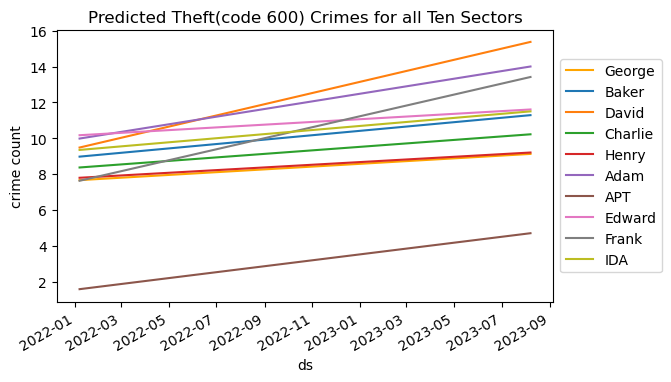

In [179]:
# code
sec_GEORGE_code_600 = pd.read_csv('sec_GEORGE_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_BAKER_code_600 = pd.read_csv('sec_BAKER_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_DAVID_code_600 = pd.read_csv('sec_DAVID_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_CHARLIE_code_600 = pd.read_csv('sec_CHARLIE_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_HENRY_code_600 = pd.read_csv('sec_HENRY_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_ADAM_code_600 = pd.read_csv('sec_ADAM_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_APT_code_600 = pd.read_csv('sec_APT_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_EDWARD_code_600 = pd.read_csv('sec_EDWARD_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_FRANK_code_600 = pd.read_csv('sec_FRANK_code_600',
                    index_col='ds', 
                    parse_dates=True)
sec_IDA_code_600 = pd.read_csv('sec_IDA_code_600',
                    index_col='ds', 
                    parse_dates=True)
# Visualizing predicted crime values of all the sectors
  
# to set the plot size
#plt.figure(figsize=(8, 4))
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
  
# using plot method to plot yhat.
# in plot method we set the label and color of the curve.
sec_GEORGE_code_600['yhat'].plot(label='George', color='orange')
sec_BAKER_code_600['yhat'].plot(label='Baker')
sec_DAVID_code_600['yhat'].plot(label='David')
sec_CHARLIE_code_600['yhat'].plot(label='Charlie')  
sec_HENRY_code_600['yhat'].plot(label='Henry') 
sec_ADAM_code_600['yhat'].plot(label='Adam')
sec_APT_code_600['yhat'].plot(label='APT')
sec_EDWARD_code_600['yhat'].plot(label='Edward')
sec_FRANK_code_600['yhat'].plot(label='Frank')
sec_IDA_code_600['yhat'].plot(label='IDA')
# adding title to the plot
plt.title('Predicted Theft(code 600) Crimes for all Ten Sectors')
  
# adding Label to the x-axis
plt.xlabel('ds')
plt.ylabel('crime count') 
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Prophet Model Forecast Plot for all the ten sectors for Burglary(601 code)  crimes<a id='forecast_plots_burglary'>

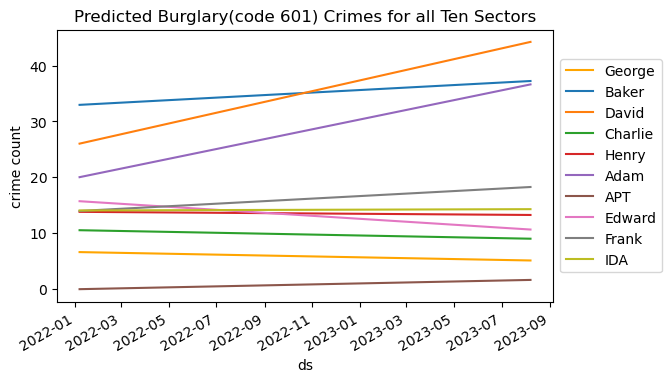

In [180]:
# code
sec_GEORGE_code_601 = pd.read_csv('sec_GEORGE_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_BAKER_code_601 = pd.read_csv('sec_BAKER_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_DAVID_code_601 = pd.read_csv('sec_DAVID_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_CHARLIE_code_601 = pd.read_csv('sec_CHARLIE_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_HENRY_code_601 = pd.read_csv('sec_HENRY_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_ADAM_code_601 = pd.read_csv('sec_ADAM_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_APT_code_601 = pd.read_csv('sec_APT_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_EDWARD_code_601 = pd.read_csv('sec_EDWARD_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_FRANK_code_601 = pd.read_csv('sec_FRANK_code_601',
                    index_col='ds', 
                    parse_dates=True)
sec_IDA_code_601 = pd.read_csv('sec_IDA_code_601',
                    index_col='ds', 
                    parse_dates=True)
# Visualizing predicted crime values of all the sectors
  
# to set the plot size
#plt.figure(figsize=(8, 4))
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
  
# using plot method to plot yhat.
# in plot method we set the label and color of the curve.
sec_GEORGE_code_601['yhat'].plot(label='George', color='orange')
sec_BAKER_code_601['yhat'].plot(label='Baker')
sec_DAVID_code_601['yhat'].plot(label='David')
sec_CHARLIE_code_601['yhat'].plot(label='Charlie')  
sec_HENRY_code_601['yhat'].plot(label='Henry') 
sec_ADAM_code_601['yhat'].plot(label='Adam')
sec_APT_code_601['yhat'].plot(label='APT')
sec_EDWARD_code_601['yhat'].plot(label='Edward')
sec_FRANK_code_601['yhat'].plot(label='Frank')
sec_IDA_code_601['yhat'].plot(label='IDA')
# adding title to the plot
plt.title('Predicted Burglary(code 601) Crimes for all Ten Sectors')
  
# adding Label to the x-axis
plt.xlabel('ds')
plt.ylabel('crime count')   
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Summary<a id='summary'>

* Modeling will be done with twenty time series (ten Austin Police Department Sectors and two major crimes with code of 600 and 601
* code 600 is for Thefts and code 601 for Burglary
* Ten sectors are George, Henry, Baker, David, Charlie,Adam, APT, Edward,Frank, IDA, APT
* Dates will be from 2022 and above
* I did downsampling to make it a weekly time series
* I implemented Pivot method so each time series is a separate column
* I am using two methods for modeling this multiple time series, viz.,Auto_Arima method and Prophet method
* I split the data where cut off date for train set is 2022-12-30
* Forecast for both the methods were evaluated based on MAPE values. 
* Auto_arima gave almost the mean of MAPE which is twice the mean of MAPE from Prophet.
* I attempted to display the forecast for all the time series for each crime respectively. Graph shows straigt lines instead of time series wavy lines. Not sure if it is due to the very negligible differences in the series for yhat values.
* I had applied only one time series with XGBoost algorithm. Given more time, I would apply for all the time series and evaluate its performance.
* There is a lot of scope to imporve this project. Given more time, I would have tried to test with  more powerful regression algoriths like RandomForestRegressor, LightGBM ensemble algorithm. 

